In [35]:
import os
import boto3
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.tree import DecisionTreeRegressor
import mlflow
import warnings
import requests

In [36]:
warnings.filterwarnings('ignore') # ignore warnings

In [37]:
pd.options.display.max_rows = None # display all rows of dataframes

# Part 1: Exploratory Data Analysis and Data Preprocessing

In [38]:
data = pd.read_csv("get_around_pricing_project.csv")
# it's easier to work with the columns when all their names are in lowercase
data.columns = data.columns.str.lower()
data.drop(columns=['unnamed: 0'], inplace=True) # drop the first column

In [39]:
# in order not to read the file every time we need to reload the data
prices = data.copy()

## Displaying basic stats about the dataset:

In [40]:
# Basic stats about the dataframe
print(f"Number of rows : {prices.shape[0]}")
print()

print("Basic info: ")
prices.info()
print()

print("Display of prices: ")
display(prices.head())
print()

print("Basics statistics: ")
data_desc = prices.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*prices.isnull().sum()/prices.shape[0]), columns=['% missing values']))

Number of rows : 4843

Basic info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183



Basics statistics: 


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000



Percentage of missing values: 


,% missing values
model_key,0.0
mileage,0.0
engine_power,0.0
fuel,0.0
paint_color,0.0
car_type,0.0
private_parking_available,0.0
has_gps,0.0
has_air_conditioning,0.0
automatic_car,0.0


## Preprocessing:

In [41]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "rental_price_per_day"

X = prices.drop(target_variable, axis = 1)
Y = prices.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    106
1    264
2    101
3    158
4    183
Name: rental_price_per_day, dtype: int64

X :
  model_key  mileage  engine_power    fuel paint_color     car_type   
0   Citroën   140411           100  diesel       black  convertible  \
1   Citroën    13929           317  petrol        grey  convertible   
2   Citroën   183297           120  diesel       white  convertible   
3   Citroën   128035           135  diesel         red  convertible   
4   Citroën    97097           160  diesel      silver  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car   
0                       True     True                 False          False  \
1                       True     True                 False          False   
2                      False    False                 False          False   
3                       True     True                 False          False   
4                       True     True     

### Separating numerical and categorical features:

In [42]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
bool_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    elif 'object' in str(t) :
        categorical_features.append(i)
    else:
        bool_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)
print('Found boolean features ', bool_features)

Found numeric features  ['mileage', 'engine_power']
Found categorical features  ['model_key', 'fuel', 'paint_color', 'car_type']
Found boolean features  ['private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


### Splitting our data between train and test sets:

In [43]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



### Building preprocessing pipelines and transforming our data:

In [44]:
def bool_to_numeric(col):
    """Transform boolean values into numeric values"""
    col = col.replace({True: 1, False: 0})
    return col
    
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
bool_transformer = FunctionTransformer(bool_to_numeric)

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', bool_transformer, bool_features)
    ])

In [46]:
# Preprocessings on train set
print("X_train before preprocessing: ")
#display(X_train.head())
print("Performing preprocessings on train set...")
# X_train = preprocessor.fit_transform(X_train)
print("X_train after preprocessing: ")
#display(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("X_test before preprocessing: ")
#display(X_test.head())
print("Performing preprocessings on test set...")
# X_test = preprocessor.transform(X_test) # Don't fit again !
print("X_test after preprocessing: ")
#display(X_test)
print('preprocessings on test set...Done.')

X_train before preprocessing: 
Performing preprocessings on train set...
X_train after preprocessing: 
preprocessings on train set...Done.
X_test before preprocessing: 
Performing preprocessings on test set...
X_test after preprocessing: 
preprocessings on test set...Done.


In [47]:
def get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features):
    # Feature importance
    feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    feature_names += numeric_features
    feature_names += bool_features

    # Extract coefficient values
    coefs = model.named_steps['regressor'].coef_

    # Sort them and reverse (highest on top)
    inds = np.argsort(coefs)[::-1]
    sorted_coefs = coefs[inds]
    sorted_features = np.array(feature_names)[inds]

    fig = plt.figure(figsize=(10, 5))
    plt.bar(sorted_features, sorted_coefs)
    plt.title('Feature importances')
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=90)
    fig.savefig(f'images/feat_imp_{run_name}', bbox_inches='tight')

We won't be transforming our data right away as we'll be building a pipeline integrated with the model

## Run MLFLOW experiment:

In [48]:
mlflow.set_experiment('getaround_pricing_project')
mlflow.sklearn.autolog(log_post_training_metrics=False, silent=True)


### LinearRegression:

Training done.


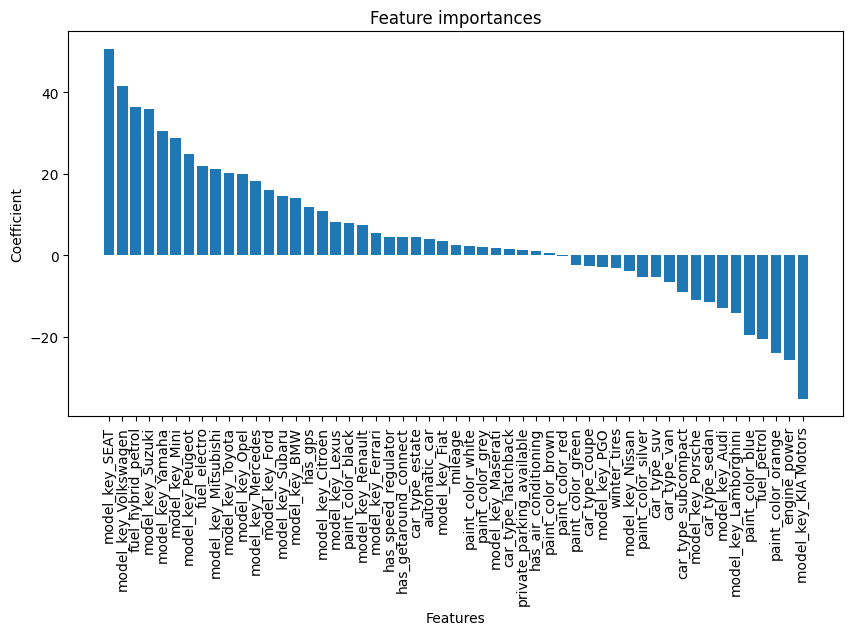

In [49]:
run_name = 'linear_regression_baseline'
with mlflow.start_run(run_name=run_name, ) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

### DecisionTree:

In [50]:
run_name = 'decision_tree'
with mlflow.start_run(run_name=run_name) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(max_depth=10, random_state=42))])
    model.fit(X_train, Y_train)
    
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

Training done.


### RandomForest:

In [51]:
run_name = 'random_forest'
with mlflow.start_run(run_name=run_name) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(max_depth=10, random_state=42))])
    model.fit(X_train, Y_train)
    
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()
    

Training done.


### Ridge:

Training done.


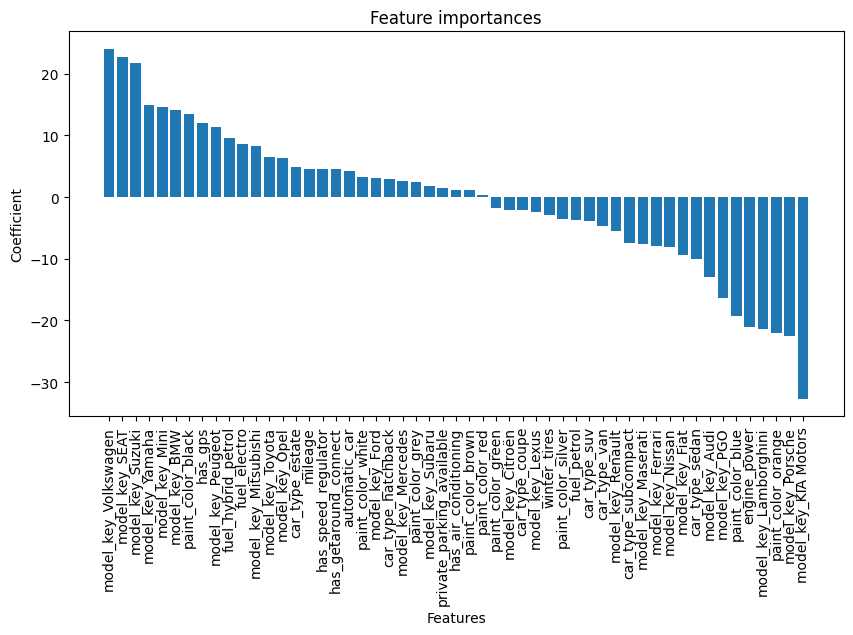

In [52]:
run_name = 'ridge'
with mlflow.start_run(run_name=run_name, ) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1, random_state=42))])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

### Lasso:

Training done.


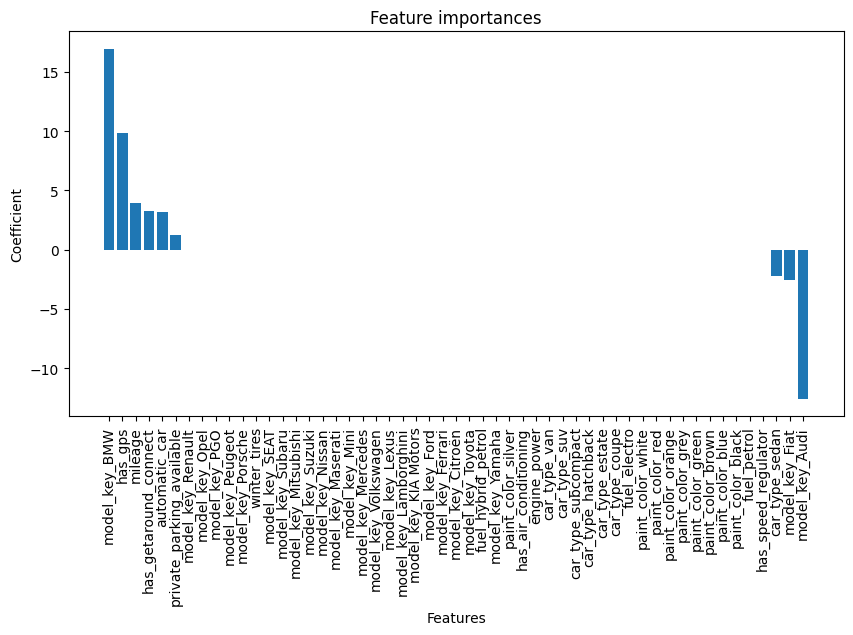

In [53]:
run_name = 'lasso'
with mlflow.start_run(run_name=run_name, ) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha=1, random_state=42))])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

### Elasticnet:

Training done.


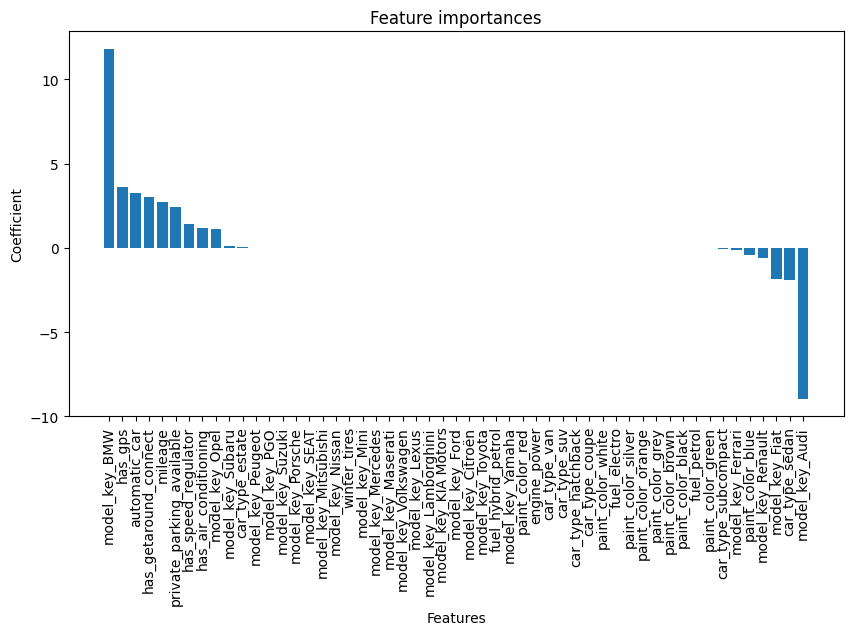

In [54]:
run_name = 'elasticnet'
with mlflow.start_run(run_name=run_name, ) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=1, random_state=42))])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

### RandomForest with feature selection:

In [55]:
run_name = 'random_forest_feature_selection_40'
with mlflow.start_run(run_name=run_name) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('feature_selector', SelectKBest(f_regression, k=40)), ('regressor', RandomForestRegressor(max_depth=10, random_state=42))])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

Training done.


### GridSearchCV RandomForest:

In [56]:
# Grid of values to be tested
run_name = 'random_forest_gridsearch'
with mlflow.start_run(run_name=run_name, ) as run:
    params = {
    'max_depth': [10, 12, 14, 16, 18, 20],
    'min_samples_split': [2, 4, 8, 10, 12, 14, 16],
    'n_estimators': [60, 80, 100, 200, 300, 400, 500]
    }
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GridSearchCV(RandomForestRegressor(random_state=42), params, cv=5, n_jobs=-1))])
    model.fit(X_train, Y_train)
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    mlflow.log_param("best_params", model.named_steps['regressor'].best_params_)
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

Training done.


### XGBRegressor

In [57]:
run_name = 'xgbr'
with mlflow.start_run(run_name=run_name) as run:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, alpha=0.1, random_state=42))])
    model.fit(X_train, Y_train)
    
    print("Training done.")
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    mlflow.log_metric("training_r2_score",r2_score(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_absolute_error",mean_absolute_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_mean_squared_error",mean_squared_error(Y_train, Y_train_pred))
    mlflow.log_metric("training_root_mean_squared_error",mean_squared_error(Y_train, Y_train_pred, squared=False))
    mlflow.log_metric("testing_r2_score",r2_score(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_absolute_error",mean_absolute_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_mean_squared_error",mean_squared_error(Y_test, Y_test_pred))
    mlflow.log_metric("testing_root_mean_squared_error",mean_squared_error(Y_test, Y_test_pred, squared=False))
    try:
        get_feature_imp(run_name, model, preprocessor, numeric_features, categorical_features, bool_features)
        mlflow.log_artifact(f'images/feat_imp_{run_name}.png')
    except:
        pass
    mlflow.end_run()

Training done.


In [2]:
mlflow.get_tracking_uri()

'https://ns-mlflow-tracking.herokuapp.com/'

In [11]:
# Read data 
df = pd.DataFrame(dict({
  "model_key": "Citroën",
  "mileage": 13929,
  "engine_power": 317,
  "fuel": "petrol",
  "paint_color": "black",
  "car_type": "convertible",
  "private_parking_available": True,
  "has_gps": True,
  "has_air_conditioning": True,
  "automatic_car": True,
  "has_getaround_connect": True,
  "has_speed_regulator": True,
  "winter_tires": True
}), index=[0])

# Log model from mlflow 
#logged_model = 'runs:/aa0c7eec64cc470ab8add9ca89dd168b/model'

# Load model as a PyFuncModel.
#loaded_model = mlflow.pyfunc.load_model(logged_model)
#prediction = loaded_model.predict(df)

In [12]:
df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Citroën,13929,317,petrol,black,convertible,True,True,True,True,True,True,True


In [26]:
# Read data 
import pandas as pd
import requests
import json
df = pd.DataFrame({
  "model_key": "Citroën",
  "mileage": 13929,
  "engine_power": 317,
  "fuel": "petrol",
  "paint_color": "black",
  "car_type": "convertible",
  "private_parking_available": True,
  "has_gps": True,
  "has_air_conditioning": True,
  "automatic_car": True,
  "has_getaround_connect": True,
  "has_speed_regulator": True,
  "winter_tires": True
}, index=[0])
data = df.to_dict(orient='records')[0]
response = requests.post('http://ec2-35-180-36-210.eu-west-3.compute.amazonaws.com/predict', json=data)

In [29]:
data

{'model_key': 'Citroën',
 'mileage': 13929,
 'engine_power': 317,
 'fuel': 'petrol',
 'paint_color': 'black',
 'car_type': 'convertible',
 'private_parking_available': False,
 'has_gps': False,
 'has_air_conditioning': False,
 'automatic_car': False,
 'has_getaround_connect': False,
 'has_speed_regulator': False,
 'winter_tires': False}

In [27]:
df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Citroën,13929,317,petrol,black,convertible,False,False,False,False,False,False,False


In [28]:
response.json()['prediction']

175.61508178710938

In [60]:
model_name = "getaround_xgbr"
client = mlflow.MlflowClient()
model_version = client.get_registered_model(name="svd_surprise").latest_versions[0].version
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

2023/07/13 13:48:39 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.2, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [61]:
# Read data 
df = pd.DataFrame(dict({
  "model_key": "Citroën",
  "mileage": 13929,
  "engine_power": 317,
  "fuel": "petrol",
  "paint_color": "black",
  "car_type": "convertible",
  "private_parking_available": True,
  "has_gps": True,
  "has_air_conditioning": True,
  "automatic_car": True,
  "has_getaround_connect": True,
  "has_speed_regulator": True,
  "winter_tires": True
}), index=[0])
model.predict(df)

array([237.79216], dtype=float32)

In [4]:
data

{'model_key': 'Citroën',
 'mileage': 13929,
 'engine_power': 317,
 'fuel': 'petrol',
 'paint_color': 'black',
 'car_type': 'convertible',
 'private_parking_available': True,
 'has_gps': True,
 'has_air_conditioning': True,
 'automatic_car': True,
 'has_getaround_connect': True,
 'has_speed_regulator': True,
 'winter_tires': True}

In [6]:
response

<Response [500]>